In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F

In [2]:
sequence_length = 10
batch_size = 2
input_dim = 256
output_dim = 256
x = torch.rand((batch_size,sequence_length,input_dim))

In [3]:
x.size()

torch.Size([2, 10, 256])

In [4]:
qkv_layer = nn.Linear(input_dim,3*output_dim)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([2, 10, 768])

Text(0.5, 1.0, 'qkv distribution')

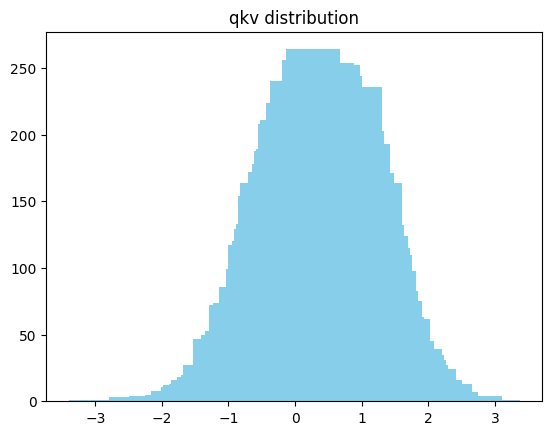

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv,bins=200,min=3,max=3)
x_val =  np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center',color=['skyblue'])
plt.title('qkv distribution')

In [8]:
num_heads = 8
head_dim = output_dim//num_heads
qkv = qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)
qkv.shape

torch.Size([2, 10, 8, 96])

In [9]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([2, 8, 10, 96])

In [10]:
q,k,v = qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([2, 8, 10, 32]),
 torch.Size([2, 8, 10, 32]),
 torch.Size([2, 8, 10, 32]))

In [11]:
import math
d_k = q.size(3)
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)

In [12]:
print(scaled.shape)
k.T.shape

torch.Size([2, 8, 10, 10])


/tmp/ipykernel_18/62803528.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  k.T.shape


torch.Size([32, 10, 8, 2])

In [13]:
y =  torch.rand(2,3)
torch.transpose(y,0,1)
torch.transpose(y,1,0)

tensor([[0.6594, 0.5554],
        [0.9320, 0.4679],
        [0.1027, 0.3177]])

In [14]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
(scaled+mask)[0][0]

tensor([[-0.0102,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.0063,  0.0471,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.0182,  0.0738,  0.2238,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [-0.0793, -0.0257,  0.1136, -0.0170,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.0350,  0.0574,  0.2112,  0.1005,  0.0662,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [-0.0541,  0.0148,  0.1442, -0.0186, -0.0209,  0.0394,    -inf,    -inf,
            -inf,    -inf],
        [-0.0993, -0.1176,  0.1115, -0.0407, -0.0528,  0.0303,  0.0810,    -inf,
            -inf,    -inf],
        [ 0.0453,  0.0939,  0.2177,  0.0732,  0.0623,  0.0658,  0.1579,  0.0947,
            -inf,    -inf],
        [-0.0159, -0.0340,  0.1397, -0.0177, -0.0411, -0.0114,  0.0121, -0.0468,
          0.0298,    -inf],
        [-0.0635, -

In [16]:
scaled += mask

In [17]:
np.exp(0.5596)/(np.exp(0.5596)+np.exp(0.404))

0.5388217044001664

In [18]:
attention = torch.nn.functional.softmax(scaled,dim=-1)

In [19]:
attention.shape

torch.Size([2, 8, 10, 10])

In [20]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4898, 0.5102, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3044, 0.3218, 0.3739, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2308, 0.2435, 0.2799, 0.2457, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1882, 0.1924, 0.2244, 0.2009, 0.1941, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1548, 0.1659, 0.1888, 0.1604, 0.1601, 0.1700, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1305, 0.1282, 0.1612, 0.1384, 0.1368, 0.1486, 0.1563, 0.0000, 0.0000,
         0.0000],
        [0.1180, 0.1239, 0.1402, 0.1213, 0.1200, 0.1204, 0.1321, 0.1240, 0.0000,
         0.0000],
        [0.1090, 0.1071, 0.1274, 0.1088, 0.1063, 0.1095, 0.1121, 0.1057, 0.1141,
         0.0000],
        [0.0998, 0.0968, 0.1141, 0.0978, 0.0978, 0.0973, 0.1046, 0.0944, 0.0967,
         0.1009]], grad_fn=<

In [21]:
values = torch.matmul(attention,v)
values.shape

torch.Size([2, 8, 10, 32])

In [22]:
def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = torch.nn.functional.softmax(scaled,dim=-1)
    values = torch.matmul(attention,v)
    return values,attention


In [23]:
values,attention =  scaled_dot_product(q,k,v,mask=mask)

In [24]:
attention.shape

torch.Size([2, 8, 10, 10])

In [25]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4898, 0.5102, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3044, 0.3218, 0.3739, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2308, 0.2435, 0.2799, 0.2457, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1882, 0.1924, 0.2244, 0.2009, 0.1941, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1548, 0.1659, 0.1888, 0.1604, 0.1601, 0.1700, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1305, 0.1282, 0.1612, 0.1384, 0.1368, 0.1486, 0.1563, 0.0000, 0.0000,
         0.0000],
        [0.1180, 0.1239, 0.1402, 0.1213, 0.1200, 0.1204, 0.1321, 0.1240, 0.0000,
         0.0000],
        [0.1090, 0.1071, 0.1274, 0.1088, 0.1063, 0.1095, 0.1121, 0.1057, 0.1141,
         0.0000],
        [0.0998, 0.0968, 0.1141, 0.0978, 0.0978, 0.0973, 0.1046, 0.0944, 0.0967,
         0.1009]], grad_fn=<

In [26]:
values.size()

torch.Size([2, 8, 10, 32])

In [27]:
values = values.reshape(batch_size,sequence_length,num_heads*head_dim)
values.size()

torch.Size([2, 10, 256])

In [28]:
linear_layer = nn.Linear(output_dim,output_dim)

In [29]:
out =  linear_layer(values)

In [30]:
out.shape

torch.Size([2, 10, 256])

In [31]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = torch.nn.functional.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [32]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
